In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Necessary Libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
# custom dataset class for loading the images
class CustomDataset(Dataset):
    def __init__(self, images, ela_images, labels, transform=None):
        self.images = images
        self.ela_images = ela_images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        ela_image = self.ela_images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)
            ela_image = self.transform(ela_image)

        return image, ela_image, label

# Model

In [5]:
import pickle
#Load the loaders
with open('/content/drive/MyDrive/HKBU/CVPR/data_loaders.pkl', 'rb') as f:
    train_loader, test_loader, valid_loader = pickle.load(f)

In [6]:
# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)  # Replace the final fully connected layer for binary classification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.8MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Loss Function and Optimizer

In [7]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# training the model
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, ela_images, labels in train_loader:
        ela_images = ela_images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(ela_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    train_accuracy = correct / total
    train_loss = running_loss / len(train_loader)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, ela_images, labels in valid_loader:
            ela_images = ela_images.to(device)
            labels = labels.to(device)

            outputs = model(ela_images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    valid_accuracy = correct / total
    valid_loss = running_loss / len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Valid Loss: {valid_loss:.4f} - Valid Accuracy: {valid_accuracy:.4f}")

Epoch 1/15 - Train Loss: 0.6979 - Train Accuracy: 0.5159 - Valid Loss: 0.7210 - Valid Accuracy: 0.3676
Epoch 2/15 - Train Loss: 0.6885 - Train Accuracy: 0.5392 - Valid Loss: 0.6998 - Valid Accuracy: 0.4035
Epoch 3/15 - Train Loss: 0.6801 - Train Accuracy: 0.5632 - Valid Loss: 0.7433 - Valid Accuracy: 0.3776
Epoch 4/15 - Train Loss: 0.6632 - Train Accuracy: 0.5966 - Valid Loss: 0.6705 - Valid Accuracy: 0.6023
Epoch 5/15 - Train Loss: 0.6549 - Train Accuracy: 0.5967 - Valid Loss: 0.6595 - Valid Accuracy: 0.6048
Epoch 6/15 - Train Loss: 0.6292 - Train Accuracy: 0.6359 - Valid Loss: 0.6581 - Valid Accuracy: 0.6341
Epoch 7/15 - Train Loss: 0.6068 - Train Accuracy: 0.6566 - Valid Loss: 0.6859 - Valid Accuracy: 0.5948
Epoch 8/15 - Train Loss: 0.5736 - Train Accuracy: 0.6871 - Valid Loss: 0.8473 - Valid Accuracy: 0.4461
Epoch 9/15 - Train Loss: 0.5382 - Train Accuracy: 0.7199 - Valid Loss: 0.7018 - Valid Accuracy: 0.5781
Epoch 10/15 - Train Loss: 0.4850 - Train Accuracy: 0.7614 - Valid Loss: 0

# Evaluation

In [10]:
# evaluation of the model on the test set
model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, ela_images, labels in test_loader:
        ela_images = ela_images.to(device)
        labels = labels.to(device)

        outputs = model(ela_images)
        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy : %0.2f" % (accuracy*100),'%')
print("Precision: %0.2f" % (precision*100),'%')
print("Recall   :", recall)
print("F1-Score :", f1)

Accuracy : 60.47 %
Precision: 53.28 %
Recall   : 0.3459715639810427
F1-Score : 0.41954022988505746


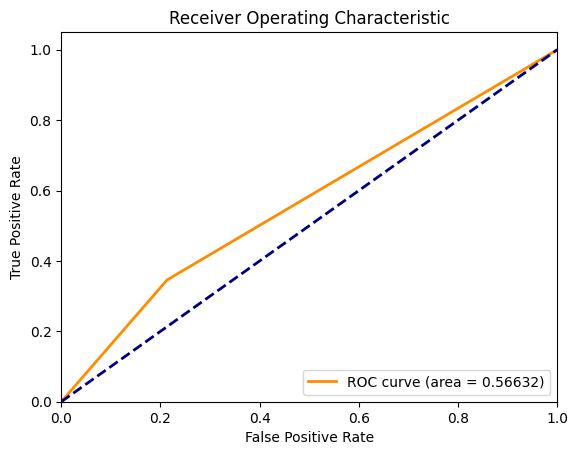

In [11]:
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

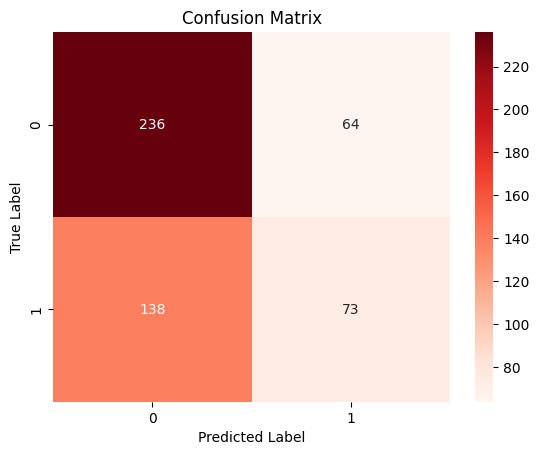

In [12]:
confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure()
sns.heatmap(confusion, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

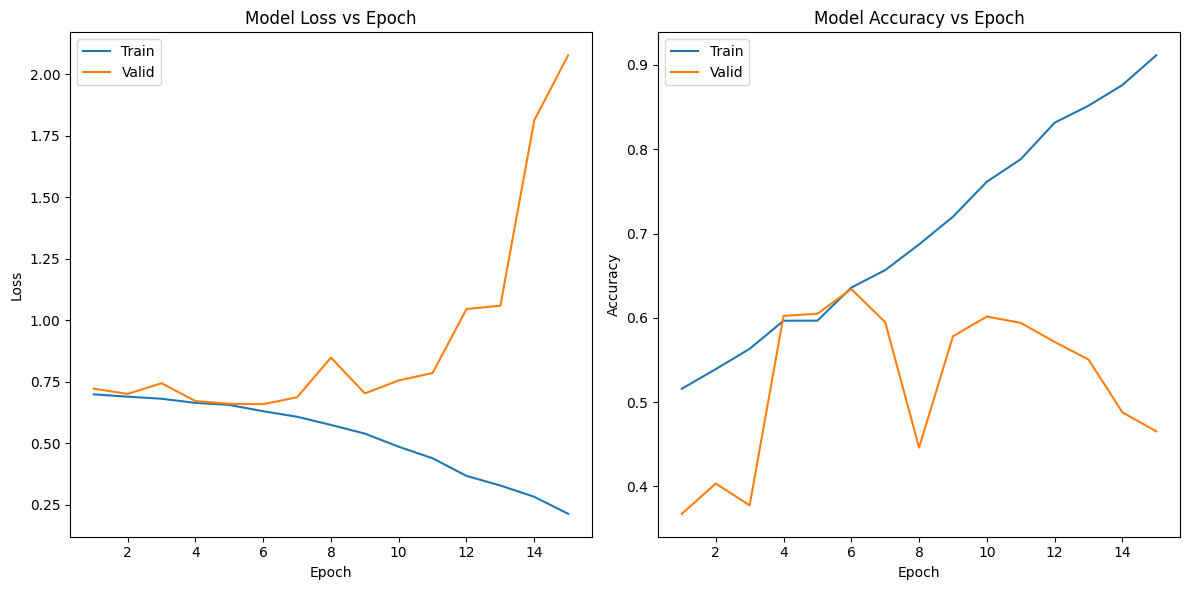

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot model loss vs epoch
axs[0].plot(range(1, num_epochs+1), train_losses, label='Train')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Valid')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Model Loss vs Epoch')
axs[0].legend()

# plot model accuracy vs epoch
axs[1].plot(range(1, num_epochs+1), train_accuracies, label='Train')
axs[1].plot(range(1, num_epochs+1), valid_accuracies, label='Valid')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Model Accuracy vs Epoch')
axs[1].legend()

plt.tight_layout()
plt.show()